In [1]:
import numpy as np
import sys
import json
from matplotlib import pyplot as plt
import meshplot as mp
import cv2
import svgwrite
import igl
sys.path.append("../src/")

# 1. Gradient Descent with Backtracking Line Search 

In [2]:
with open('../data/dinosaur.json', 'r') as infile:
    [V, F] = json.load(infile)
    V = np.array(V)
    F = np.array(F)

In [3]:
from geometry import compute_mesh_centroid

shader = {"flat":True, # Flat or smooth shading of triangles
           "wireframe": True, "wire_width": 0.03, "wire_color": "black", # Wireframe rendering
           "width": 600, "height": 600, # Size of the viewer canvas
           "antialias": True, # Antialising, might not work on all GPUs
           "scale": 2.0, # Scaling of the model
           "side": "DoubleSide", # FrontSide, BackSide or DoubleSide rendering of the triangles
           "colormap": "viridis", "normalize": [None, None], # Colormap and normalization for colors
           "background": "#ffffff", # Background color of the canvas
           "line_width": 1.0, "line_color": "black", # Line properties of overlay lines
           "bbox": False, # Enable plotting of bounding box
           "point_color": "red", "point_size": 0.01 # Point properties of overlay points
          }

def draw_meshes_comparison(V1, F1, V2, F2, color1, color2):
    mesh_plot = mp.plot(V1, F1, c = color1, return_plot=True)
    mesh_plot.add_mesh(V2, F2, c = color2, shading=shader)
    
    center0 = np.array(compute_mesh_centroid(V2, F2))
    center1 = center0.copy()
    center1[1] = 0
    vertices = np.vstack([center0, center1])
    mesh_plot.add_points(vertices, shading={"point_color": "black", "point_size": 0.1})
    mesh_plot.add_edges(vertices, np.array([[0, 1]]), shading={"line_color": "black", "line_width" : 0.5});

In [4]:
from geometry import compute_support_line_center
from linesearch import gradient_descent_with_line_search
x_csl = compute_support_line_center(V)
[V1, F, objective, running_time] = gradient_descent_with_line_search(V, F, x_csl, w = 10, obj_tol = 1E-8, iter = 10000, theta = 1.0, beta = 0.5, c = 0.02)

mesh_plot = draw_meshes_comparison(V, F, V1, F, np.array([0.3, 0.3, 0.3]), np.array([1.0, 1.0, 0]))
print(running_time)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5046897…

3.0994415283203125e-06


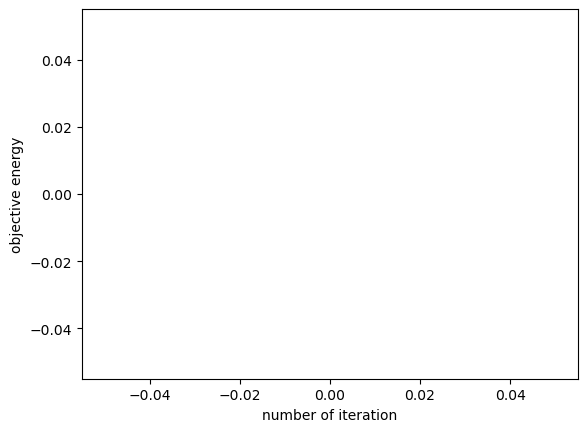

In [5]:
fig = plt.figure()
plt.plot(objective)
plt.xlabel("number of iteration")
plt.ylabel("objective energy")
plt.show()

# 2. BFGS Approximated Hessian Matrix and its Inverse Matrix

In [6]:
def f(x):
    return np.linalg.norm(x) ** 2

def grad_f(x):
    return 2 * x

In [7]:
from bfgs import compute_approximate_hessian_matrix
x = np.array([1, 1])
p = -grad_f(x)
alpha = 1.0
y = x + alpha * p
sk = (y - x).reshape(2, 1)
yk = (grad_f(y) - grad_f(x)).reshape(2, 1)
Bk = np.identity(2)
Bnew = compute_approximate_hessian_matrix(sk, yk, Bk)

In [8]:
from bfgs import compute_inverse_approximate_hessian_matrix
x = np.array([1, 1])
p = -grad_f(x)
alpha = 1.0
y = x + alpha * p
sk = (y - x).reshape(2, 1)
yk = (grad_f(y) - grad_f(x)).reshape(2, 1)
invBk = np.identity(2)
invBnew = compute_inverse_approximate_hessian_matrix(sk, yk, invBk)


The matrix multiplation of the two matrix should be indentity matrix.

In [9]:
print(Bnew @ invBnew)

[[1. 0.]
 [0. 1.]]


# 3. BFGS with Backtracking Line Search 

In [10]:
from geometry import compute_support_line_center
from bfgs import bfgs_with_line_search
x_csl = compute_support_line_center(V)
[V1, F, objective, running_time] = bfgs_with_line_search(V, F, x_csl, w = 10, obj_tol = 1E-8, iter = 10000, theta = 1.0, beta = 0.5, c = 0.02)

mesh_plot = draw_meshes_comparison(V, F, V1, F, np.array([0.3, 0.3, 0.3]), np.array([1.0, 1.0, 0]))
print(running_time)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.5046897…

1.9073486328125e-06


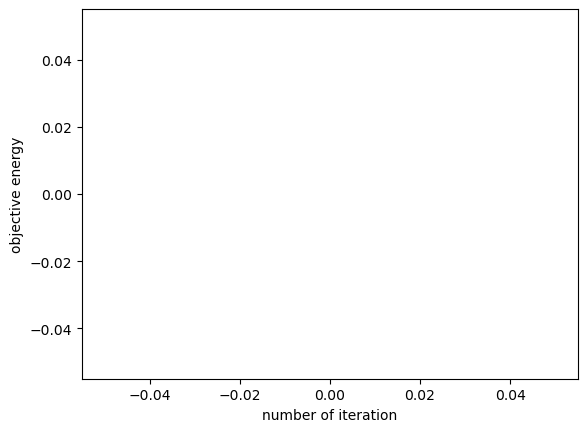

In [11]:
fig = plt.figure()
plt.plot(objective)
plt.xlabel("number of iteration")
plt.ylabel("objective energy")
plt.show()

# 4. Create your own Mesh

# 4.1 Load the image

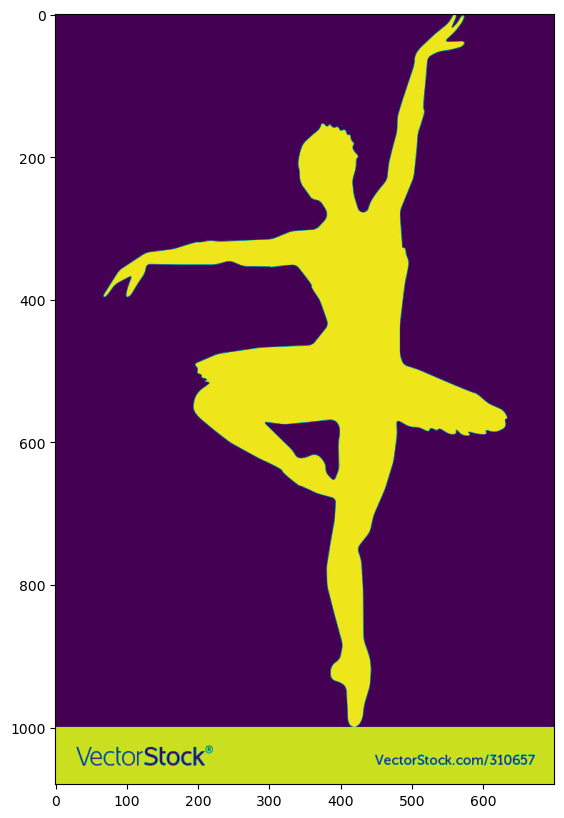

In [12]:
#read the image
image_path = "../data/dance.png"
img = cv2.imread(image_path, 1) 

# convert the image to grey scale
imgrey = 255 - cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# show image
plt.figure(figsize = (10, 10))
plt.imshow(imgrey)
plt.show()

# 4.2 Make Flat Bottom Line

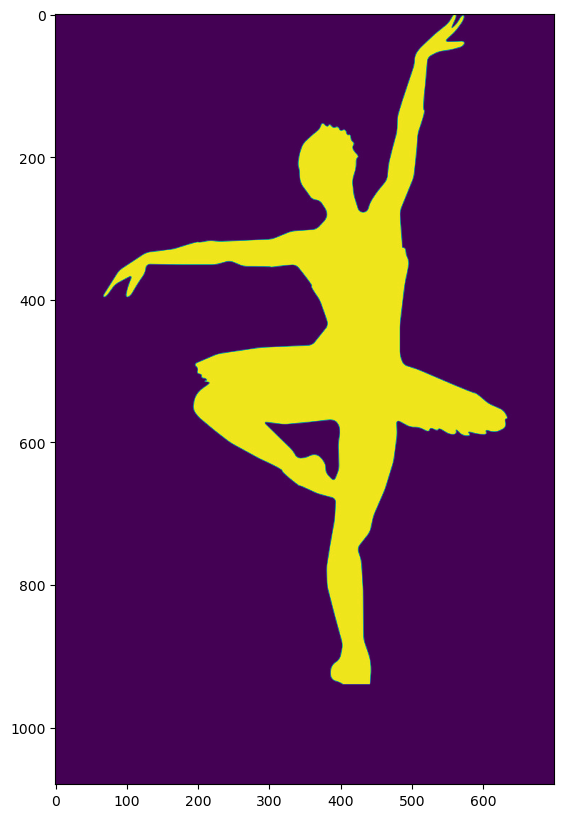

In [13]:
#cut from Y = maxX
maxX = 940
imcut = imgrey.copy()
imcut[maxX : imcut.shape[0] + 1, :] = 0

# show image
plt.figure(figsize = (10, 10))
plt.imshow(imcut)
plt.show()

# 4.3 Extract and Simplify the Boundary Curves

To simplify the boundary curves of the final mesh, we collapse the edge if its edge length is smaller than edge_length_tot.

In [14]:
edge_length_tot = 10.0

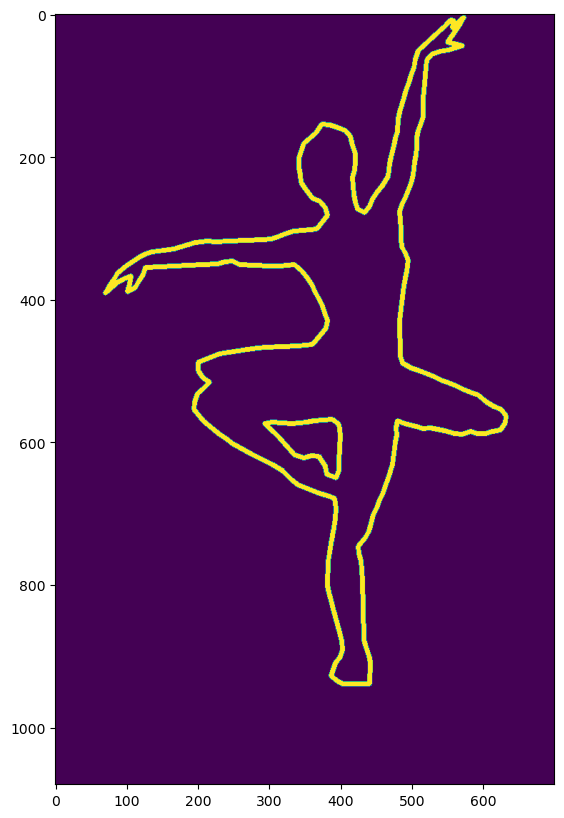

In [15]:
# Extract Boundary
ret, thresh = cv2.threshold(imcut, 127, 255, 0)
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = list(contours)
plt.figure(figsize = (10, 10))
imContour = np.zeros(imcut.shape)

# Compute Point With Highest Y coordinate
maxY = 0
for k, _ in enumerate(contours):
    current_points = contours[k][:, 0]
    for pt in current_points:
        maxY = max(pt[1], maxY)
        
boundary_points = []

# draw countour
for k, _ in enumerate(contours):
    trimmed_points = []
    current_points = contours[k][:, 0]
    prev_pt = np.array(current_points[-1])
    for pt in current_points:
        curr_pt = np.array(pt)
        if np.linalg.norm(prev_pt - curr_pt) > edge_length_tot or pt[1] == maxY:
            prev_pt = curr_pt
            trimmed_points.append([pt[0], pt[1]])
            
    contours[k] = np.array([trimmed_points])
    if contours[k].shape[1] > 0:
        imContour = cv2.drawContours(imContour, contours, k, (255, 255, 255), 6)
        boundary_points.append(trimmed_points)

        
# scale boundary points
scale = max(imcut.shape[0], imcut.shape[1])
for pts in boundary_points:
    for pt in pts:
        pt[0] /= scale
        pt[1] = (maxY - pt[1]) / scale
        
plt.imshow(imContour)
plt.show()

# 4.4 Find Holes

Some curves stored in boundary_points refers to holes in the mesh, we put their indices in to holes_indices array to compute the centroid of the holes for late remeshing. If the image has no hole, just set holes_indices to be empty list.

In [16]:
holes_indices = [1]

In [17]:
Holes =  []
for k in holes_indices:
    ct = np.array([0, 0], dtype = float)
    for pt in boundary_points[k]:
        ct += np.array(pt, dtype = float)
    ct /= len(boundary_points[k])
    Holes.append([ct[0], ct[1]])

# 4.5 Draw Mesh

In [18]:
from geometry import compute_mesh_centroid, compute_support_line_center
def draw_mesh(V, F):
    shading = {"flat":True, # Flat or smooth shading of triangles
           "wireframe":True, "wire_width": 0.03, "wire_color": "black", # Wireframe rendering
           "width": 600, "height": 600, # Size of the viewer canvas
           "antialias": True, # Antialising, might not work on all GPUs
           "scale": 2.0, # Scaling of the model
           "side": "DoubleSide", # FrontSide, BackSide or DoubleSide rendering of the triangles
           "colormap": "viridis", "normalize": [None, None], # Colormap and normalization for colors
           "background": "#ffffff", # Background color of the canvas
           "line_width": 1.0, "line_color": "black", # Line properties of overlay lines
           "bbox": False, # Enable plotting of bounding box
           "point_color": "red", "point_size": 0.01 # Point properties of overlay points
          }
    p = mp.plot(V, F, shading=shading, return_plot=True)
    center0 = np.array(compute_mesh_centroid(V, F))
    center1 = center0.copy()
    center1[1] = 0
    vertices = np.vstack([center0, center1])
    p.add_points(vertices, shading={"point_color": "black", "point_size": 0.1})
    p.add_edges(vertices, np.array([[0, 1]]), shading={"line_color": "black", "line_width" : 0.5});

In [19]:
from utility import triangulate_mesh
[V, F] = triangulate_mesh(boundary_points, Holes, 0.001)
draw_mesh(V, F)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.3245370…

# 4.6 Save as SVG

The following code is for outputing the svg files.

The unit in the following svg file is mm. A point (100, 100) refers to a point (10 cm, 10 cm).

The following code will scale your model to fit into a 10cm by 10cm bounding box. Please make sure that your name appear inside the model. 

Please keep the dimensions of the slit to their default values (1mm wide, 5mm high) and update your model so that a slit can fit. Make sure the contact line is long enough: there should be at least 1.5mm on each side, preferably 3mm on each side. PLease verify that the slit does not intersect the boundary of your drawing and leaves enough material around it.

In [20]:
bbox = igl.bounding_box(V)[0][1::2]

In [21]:
x_coords = bbox[:, 0]
y_coords = bbox[:, 1]
shift = [min(x_coords), min(y_coords), 0]

In [22]:
significant_side_length = max(max(x_coords) - min(x_coords), max(y_coords) - min(y_coords))
scale = 100.0 / significant_side_length
def transform(pt):
    return (pt - shift) * scale
scaled_V = transform(V)

In [23]:
from utility import simplify_boundary_add_slit, edges_to_closed_path
newScaledV, simplifiedBoundaryFacets = simplify_boundary_add_slit(scaled_V, F, lengthSlit=1.0, heightSlit=5.0, chamfer=0.0)
closedPaths = edges_to_closed_path(newScaledV, simplifiedBoundaryFacets)

/Users/qbecker/Documents/Courses/GC_23/MakeItStandHW3/notebook/../src/utility.py:126: UserWarning: The remaining contact line is too small on either side 1.53mm (remaining length) < 3mm (recommended)
  warnings.warn("The remaining contact line is too small on either side {:.2f}mm (remaining length) < 3mm (recommended)".format((scaled_V[path[1], 0] - scaled_V[path[0], 0] - lengthSlit) / 2.0))


In [25]:
dwg = svgwrite.Drawing('dance_1_1.svg', size=('2250px', '2250px'))

super_g = dwg.g()

for closedPath in closedPaths:
    g = dwg.g(style="stroke:#000000;stroke-width:0.5;fill:none")
    g.add(dwg.polygon(newScaledV[closedPath[:-1], :2].tolist()))
    super_g.add(g)

# 10cmx10cm box
g = dwg.g(style="stroke:#ff0000;stroke-width:0.5;fill:none")
g.add(dwg.polygon([[0.0, 0.0], [0.0, 100.0], [100.0, 100.0], [100.0, 0.0]]))
super_g.add(g)

# Blue stroke
g = dwg.g(style="font-size:8.0;font-family:Arial;stroke:#0000ff;stroke-width:0.03;fill:none")
g.add(dwg.text("<group_name>", insert=(30.0, 50.0)))
super_g.add(g)
dwg.add(super_g)
dwg.save()

# 5. Design your own Mesh

Please design 3 different meshes that are original not equilibrium.

Try to optimize them to be equilibrium and report it in your report.